# Static GCN Baseline

**Objective**: 2-layer GCN using graph structure and node features.

**Key principle**: Each node v evaluated at exactly t_first(v) + K.

In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(ROOT))

from code_lib.temporal_node_classification_builder import (
    TemporalNodeClassificationBuilder,
    load_elliptic_data,
    prepare_observation_window_graphs
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm.notebook import tqdm
import os
import random

## Configuration

In [2]:
from test_config import EXPERIMENT_CONFIG

CONFIG = EXPERIMENT_CONFIG.copy()
# GCN-specific hyperparameters (FIXED for class imbalance)
CONFIG['dropout'] = 0.3  # Reduced from 0.5 to prevent over-regularization
CONFIG['learning_rate'] = 0.001  # Reduced from 0.01 for more stable training
CONFIG['weight_decay'] = 1e-5  # Reduced from 5e-4 to allow model to fit minority class
CONFIG['epochs'] = 350
CONFIG['patience'] = 50

print(f"Device: {CONFIG['device']}")

Device: cuda


## Multi-Seed Configuration

In [3]:
SEEDS = [42, 123, 456]
RESULTS_DIR = Path('../../results/static_gcn_multi_seed')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Running experiments with {len(SEEDS)} seeds: {SEEDS}")
print(f"Results will be saved to: {RESULTS_DIR}")

Running experiments with 3 seeds: [42, 123, 456]
Results will be saved to: ../../results/static_gcn_multi_seed


In [4]:
def remove_correlated_features(nodes_df, threshold=0.95, verbose=True):
    """
    Remove highly correlated features from nodes DataFrame.
    """
    exclude_cols = {'address', 'Time step', 'class'}
    feature_cols = [col for col in nodes_df.columns
                    if col not in exclude_cols and
                    pd.api.types.is_numeric_dtype(nodes_df[col])]

    sample_size = min(10000, len(nodes_df))
    sample_df = nodes_df[feature_cols].sample(n=sample_size, random_state=42)
    corr_matrix = sample_df.corr().abs()

    to_remove = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                to_remove.add(corr_matrix.columns[j])

    features_to_keep = [col for col in feature_cols if col not in to_remove]

    if verbose:
        print(f"Original features: {len(feature_cols)}")
        print(f"Removed features:  {len(to_remove)}")
        print(f"Kept features:     {len(features_to_keep)}")

    return features_to_keep

## Load Data & Create Splits

In [5]:
nodes_df, edges_df = load_elliptic_data(CONFIG['data_dir'], use_temporal_features=True)

Loading trmporal features...
Loading node classes...
Loading edges...


In [6]:
kept_features = remove_correlated_features(nodes_df, threshold=0.95, verbose=False)

In [7]:
builder = TemporalNodeClassificationBuilder(
    nodes_df=nodes_df,
    edges_df=edges_df,
    feature_cols=kept_features,
    include_class_as_feature=False,
    add_temporal_features=True,
    cache_dir='../../graph_cache_reduced_features_fixed',
    use_cache=True,
    verbose=True
)

split = builder.get_train_val_test_split(
    train_timesteps=CONFIG['train_timesteps'],
    val_timesteps=CONFIG['val_timesteps'],
    test_timesteps=CONFIG['test_timesteps'],
    filter_unknown=True
)

print(f"Train: {len(split['train'])} nodes")
print(f"Val:   {len(split['val'])} nodes")
print(f"Test:  {len(split['test'])} nodes")

  Pre-processing node features by (address, timestep)...
  Pre-processing edges by timestep...
  Average new nodes per timestep: 16794.7
Initialized TemporalNodeClassificationBuilder
  Total nodes: 822942
  Total edges: 2868964
  Time steps: 1 to 49
  Feature columns (36): ['in_num', 'in_total_fees', 'in_mean_fees', 'in_total_btc_in', 'in_mean_btc_in']...
  Include class as feature: False
  Add temporal features: True
  Add edge weights: False

Temporal Split Summary:
  Train: timesteps 5-26, 104704 nodes
    Illicit: 6698, Licit: 98006
Training illicit ratio: 0.06397081295843521
  Val:   timesteps 27-31, 11230 nodes
    Illicit: 809, Licit: 10421
Validation illicit ratio: 0.07203918076580587
  Test:  timesteps 32-40, 45963 nodes
    Illicit: 3682, Licit: 42281
Test illicit ratio: 0.08010791288645215
Train: 104704 nodes
Val:   11230 nodes
Test:  45963 nodes


## Prepare Per-Node Graphs

Each node evaluated at t_first(v) + K.

In [8]:
device = torch.device(CONFIG['device'])

graphs = prepare_observation_window_graphs(
    builder,
    split['train'],
    split['val'],
    split['test'],
    K_values=CONFIG['observation_windows'],
    device=device
)


PREPARING OBSERVATION WINDOW GRAPHS (PER-NODE EVALUATION)

K = 1 (Each node evaluated at t_first + 1)

TRAIN split:
  Nodes to evaluate: 104,704
  Evaluation times: t=6 to t=27
  Unique graphs needed: 22
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t6_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t7_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t8_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t9_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t10_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_reduced_features_fixed/graph_t11_metaTrue_classFalse_tempTrue_weightsFalse.pt
  ✅ Loaded cached graph from ../../graph_cache_re

## GCN Model

In [9]:
class StaticGCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [10]:
def collect_detailed_predictions(model, graphs_dict, device):
    """
    Collect detailed predictions for post-hoc analysis.
    """
    model.eval()

    all_node_indices = []
    all_predictions = []
    all_probs_class_0 = []
    all_probs_class_1 = []
    all_true_labels = []
    all_eval_times = []

    with torch.no_grad():
        for eval_t, graph in graphs_dict.items():
            logits = model(graph.x, graph.edge_index)
            probs = F.softmax(logits, dim=1)

            # Extract predictions for masked nodes
            pred = logits[graph.eval_mask].argmax(dim=1).cpu().numpy()
            prob_0 = probs[graph.eval_mask, 0].cpu().numpy()
            prob_1 = probs[graph.eval_mask, 1].cpu().numpy()
            true = graph.y[graph.eval_mask].cpu().numpy()

            # Get node indices
            node_idx = torch.where(graph.eval_mask)[0].cpu().numpy()
            eval_times = np.full(len(node_idx), eval_t)

            all_node_indices.append(node_idx)
            all_predictions.append(pred)
            all_probs_class_0.append(prob_0)
            all_probs_class_1.append(prob_1)
            all_true_labels.append(true)
            all_eval_times.append(eval_times)

    return {
        'node_indices': np.concatenate(all_node_indices),
        'predictions': np.concatenate(all_predictions),
        'probs_class_0': np.concatenate(all_probs_class_0),
        'probs_class_1': np.concatenate(all_probs_class_1),
        'true_labels': np.concatenate(all_true_labels),
        'eval_times': np.concatenate(all_eval_times)
    }

## Training Functions

In [11]:
def train_epoch(model, graphs_dict, optimizer, criterion):
    """Train on all graphs in split - BATCHED VERSION for stability."""
    model.train()
    
    # Collect all masked nodes from all graphs into one batch
    all_logits = []
    all_labels = []
    
    for eval_t, graph in graphs_dict.items():
        logits = model(graph.x, graph.edge_index)
        # Only keep logits and labels for eval_mask nodes
        all_logits.append(logits[graph.eval_mask])
        all_labels.append(graph.y[graph.eval_mask])
    
    # Concatenate into single batch
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Single backward pass for all graphs
    optimizer.zero_grad()
    loss = criterion(all_logits, all_labels)
    loss.backward()
    optimizer.step()
    
    # Compute accuracy
    pred = all_logits.argmax(dim=1)
    correct = (pred == all_labels).sum().item()
    total = len(all_labels)
    
    return loss.item(), correct / total


def evaluate(model, graphs_dict):
    """Evaluate on all graphs in split."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for eval_t, graph in graphs_dict.items():
            logits = model(graph.x, graph.edge_index)
            pred = logits[graph.eval_mask].argmax(dim=1).cpu().numpy()
            true = graph.y[graph.eval_mask].cpu().numpy()
            probs = F.softmax(logits[graph.eval_mask], dim=1)[:, 1].cpu().numpy()
            
            all_preds.append(pred)
            all_labels.append(true)
            all_probs.append(probs)
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', pos_label=1, zero_division=0
    )
    auc = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.5
    
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc}

## Train Models (Multi-Seed)

In [12]:
import copy
from datetime import datetime

# Storage for all seeds
all_seeds_results = {}
all_seeds_predictions = {}

total_iterations = len(SEEDS) * len(CONFIG['observation_windows'])
current_iteration = 0

print(f"Starting multi-seed training:")
print(f"  Seeds: {SEEDS}")
print(f"  Observation windows (K): {CONFIG['observation_windows']}")
print(f"  Total training runs: {total_iterations}")
print(f"=" * 80)

start_time = datetime.now()

for seed_idx, seed in enumerate(SEEDS):
    print(f"\n{'#' * 80}")
    print(f"# SEED {seed_idx + 1}/{len(SEEDS)}: {seed}")
    print(f"{'#' * 80}\n")

    # Set all random seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    seed_results = {}
    seed_predictions = {}
    seed_models = {}

    for K in CONFIG['observation_windows']:
        current_iteration += 1

        print(f"\n{'='*70}")
        print(f"Seed {seed} | K={K} | Progress: {current_iteration}/{total_iterations}")
        print(f"{'='*70}")

        train_graphs = graphs[K]['train']['graphs']
        val_graphs = graphs[K]['val']['graphs']
        test_graphs = graphs[K]['test']['graphs']

        # Initialize model
        num_features = list(train_graphs.values())[0].x.shape[1]
        model = StaticGCN(
            num_features=num_features,
            hidden_dim=CONFIG['hidden_dim'],
            num_classes=2,
            dropout=CONFIG['dropout']
        ).to(device)

        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=CONFIG['learning_rate'],
            weight_decay=CONFIG['weight_decay']
        )

        # Class weights from train
        all_train_labels = []
        for g in train_graphs.values():
            all_train_labels.append(g.y[g.eval_mask].cpu())
        all_train_labels = torch.cat(all_train_labels).long()

        class_counts = torch.bincount(all_train_labels)
        class_weights = torch.sqrt(1.0 / class_counts.float())
        class_weights = class_weights / class_weights.sum() * 2.0
        class_weights = class_weights.to(device)

        print(f"Class distribution: {class_counts.tolist()}")
        print(f"Class weights: {class_weights.tolist()}")

        criterion = nn.CrossEntropyLoss(weight=class_weights)

        # Training loop
        best_val_f1 = 0
        patience_counter = 0
        best_model_state = None

        pbar = tqdm(range(CONFIG['epochs']), desc=f"Seed={seed}, K={K}")
        for epoch in pbar:
            train_loss, train_acc = train_epoch(model, train_graphs, optimizer, criterion)

            if (epoch + 1) % 2 == 0:
                val_metrics = evaluate(model, val_graphs)
                train_metrics = evaluate(model, train_graphs)
                pbar.set_postfix({
                    'loss': f"{train_loss:.4f}",
                    'train_f1': f"{train_metrics['f1']:.4f}",
                    'val_f1': f"{val_metrics['f1']:.4f}"
                })

                if val_metrics['f1'] > best_val_f1:
                    best_val_f1 = val_metrics['f1']
                    patience_counter = 0
                    best_model_state = copy.deepcopy(model.state_dict())
                else:
                    patience_counter += 1

                if patience_counter >= CONFIG['patience']:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Load best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        # Evaluate
        train_metrics = evaluate(model, train_graphs)
        val_metrics = evaluate(model, val_graphs)
        test_metrics = evaluate(model, test_graphs)

        print(f"\nTrain: F1={train_metrics['f1']:.4f}, AUC={train_metrics['auc']:.4f}")
        print(f"Val:   F1={val_metrics['f1']:.4f}, AUC={val_metrics['auc']:.4f}")
        print(f"Test:  F1={test_metrics['f1']:.4f}, AUC={test_metrics['auc']:.4f}")

        # Collect detailed predictions
        print("Collecting detailed predictions...")
        train_preds = collect_detailed_predictions(model, train_graphs, device)
        val_preds = collect_detailed_predictions(model, val_graphs, device)
        test_preds = collect_detailed_predictions(model, test_graphs, device)

        # Store results
        seed_results[K] = {
            'train': train_metrics,
            'val': val_metrics,
            'test': test_metrics
        }

        seed_predictions[K] = {
            'train': train_preds,
            'val': val_preds,
            'test': test_preds
        }

        seed_models[K] = model

        # Save predictions immediately
        for split_name, preds in [('train', train_preds), ('val', val_preds), ('test', test_preds)]:
            save_path = RESULTS_DIR / f"seed{seed}_k{K}_{split_name}_predictions.npz"
            np.savez_compressed(
                save_path,
                node_indices=preds['node_indices'],
                predictions=preds['predictions'],
                probs_class_0=preds['probs_class_0'],
                probs_class_1=preds['probs_class_1'],
                true_labels=preds['true_labels'],
                eval_times=preds['eval_times']
            )
        print(f"Saved predictions to {RESULTS_DIR}/seed{seed}_k{K}_*_predictions.npz")

    # Store results for this seed
    all_seeds_results[seed] = seed_results
    all_seeds_predictions[seed] = seed_predictions

    # Save metrics for this seed
    seed_metrics_data = []
    for K in CONFIG['observation_windows']:
        for split_name in ['train', 'val', 'test']:
            metrics = seed_results[K][split_name]
            seed_metrics_data.append({
                'seed': seed,
                'K': K,
                'split': split_name,
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'auc': metrics['auc']
            })

    seed_metrics_df = pd.DataFrame(seed_metrics_data)
    seed_metrics_df.to_csv(RESULTS_DIR / f'seed{seed}_metrics.csv', index=False)
    print(f"\nSaved metrics for seed {seed} to {RESULTS_DIR}/seed{seed}_metrics.csv")

end_time = datetime.now()
elapsed = end_time - start_time

print(f"\n{'=' * 80}")
print(f"Multi-seed training complete!")
print(f"Total time: {elapsed}")
print(f"Results saved to: {RESULTS_DIR}")
print(f"{'=' * 80}")

Starting multi-seed training:
  Seeds: [42, 123, 456]
  Observation windows (K): [1, 3, 5, 7]
  Total training runs: 12

################################################################################
# SEED 1/3: 42
################################################################################


Seed 42 | K=1 | Progress: 1/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=42, K=1:   0%|          | 0/350 [00:00<?, ?it/s]


Train: F1=0.3991, AUC=0.7446
Val:   F1=0.5034, AUC=0.8478
Test:  F1=0.3333, AUC=0.6663
Saved predictions to ../../results/static_gcn_multi_seed/seed42_k1_*_predictions.npz

Seed 42 | K=3 | Progress: 2/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=42, K=3:   0%|          | 0/350 [00:00<?, ?it/s]

Early stopping at epoch 218

Train: F1=0.1100, AUC=0.6454
Val:   F1=0.2596, AUC=0.6650
Test:  F1=0.0840, AUC=0.6180
Saved predictions to ../../results/static_gcn_multi_seed/seed42_k3_*_predictions.npz

Seed 42 | K=5 | Progress: 3/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=42, K=5:   0%|          | 0/350 [00:00<?, ?it/s]

Early stopping at epoch 102

Train: F1=0.1202, AUC=0.4993
Val:   F1=0.1344, AUC=0.4994
Test:  F1=0.1483, AUC=0.4998
Saved predictions to ../../results/static_gcn_multi_seed/seed42_k5_*_predictions.npz

Seed 42 | K=7 | Progress: 4/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=42, K=7:   0%|          | 0/350 [00:00<?, ?it/s]

Early stopping at epoch 104

Train: F1=0.2347, AUC=0.7466
Val:   F1=0.1787, AUC=0.6382
Test:  F1=0.2098, AUC=0.6470
Saved predictions to ../../results/static_gcn_multi_seed/seed42_k7_*_predictions.npz

Saved metrics for seed 42 to ../../results/static_gcn_multi_seed/seed42_metrics.csv

################################################################################
# SEED 2/3: 123
################################################################################


Seed 123 | K=1 | Progress: 5/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=123, K=1:   0%|          | 0/350 [00:00<?, ?it/s]

Early stopping at epoch 102

Train: F1=0.0129, AUC=0.2959
Val:   F1=0.1082, AUC=0.6555
Test:  F1=0.0232, AUC=0.3592
Saved predictions to ../../results/static_gcn_multi_seed/seed123_k1_*_predictions.npz

Seed 123 | K=3 | Progress: 6/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=123, K=3:   0%|          | 0/350 [00:00<?, ?it/s]

Early stopping at epoch 172

Train: F1=0.1462, AUC=0.6366
Val:   F1=0.2932, AUC=0.6786
Test:  F1=0.1019, AUC=0.5952
Saved predictions to ../../results/static_gcn_multi_seed/seed123_k3_*_predictions.npz

Seed 123 | K=5 | Progress: 7/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=123, K=5:   0%|          | 0/350 [00:00<?, ?it/s]


Train: F1=0.3003, AUC=0.6558
Val:   F1=0.4032, AUC=0.7108
Test:  F1=0.1982, AUC=0.5751
Saved predictions to ../../results/static_gcn_multi_seed/seed123_k5_*_predictions.npz

Seed 123 | K=7 | Progress: 8/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=123, K=7:   0%|          | 0/350 [00:00<?, ?it/s]

Early stopping at epoch 346

Train: F1=0.2982, AUC=0.6504
Val:   F1=0.4191, AUC=0.7109
Test:  F1=0.1889, AUC=0.5688
Saved predictions to ../../results/static_gcn_multi_seed/seed123_k7_*_predictions.npz

Saved metrics for seed 123 to ../../results/static_gcn_multi_seed/seed123_metrics.csv

################################################################################
# SEED 3/3: 456
################################################################################


Seed 456 | K=1 | Progress: 9/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=456, K=1:   0%|          | 0/350 [00:00<?, ?it/s]

Early stopping at epoch 102

Train: F1=0.1202, AUC=0.5000
Val:   F1=0.1344, AUC=0.5000
Test:  F1=0.1484, AUC=0.5002
Saved predictions to ../../results/static_gcn_multi_seed/seed456_k1_*_predictions.npz

Seed 456 | K=3 | Progress: 10/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=456, K=3:   0%|          | 0/350 [00:00<?, ?it/s]

Early stopping at epoch 102

Train: F1=0.1928, AUC=0.6790
Val:   F1=0.1371, AUC=0.4314
Test:  F1=0.1845, AUC=0.5954
Saved predictions to ../../results/static_gcn_multi_seed/seed456_k3_*_predictions.npz

Seed 456 | K=5 | Progress: 11/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=456, K=5:   0%|          | 0/350 [00:00<?, ?it/s]


Train: F1=0.2910, AUC=0.6480
Val:   F1=0.4228, AUC=0.7073
Test:  F1=0.1909, AUC=0.5689
Saved predictions to ../../results/static_gcn_multi_seed/seed456_k5_*_predictions.npz

Seed 456 | K=7 | Progress: 12/12
Class distribution: [98006, 6698]
Class weights: [0.41449087858200073, 1.585509181022644]


Seed=456, K=7:   0%|          | 0/350 [00:00<?, ?it/s]

Early stopping at epoch 112

Train: F1=0.1206, AUC=0.6292
Val:   F1=0.3251, AUC=0.8258
Test:  F1=0.0991, AUC=0.5532
Saved predictions to ../../results/static_gcn_multi_seed/seed456_k7_*_predictions.npz

Saved metrics for seed 456 to ../../results/static_gcn_multi_seed/seed456_metrics.csv

Multi-seed training complete!
Total time: 0:10:49.205561
Results saved to: ../../results/static_gcn_multi_seed


## Results Summary

In [13]:
# Aggregate results across all seeds
aggregated_results = []

for seed in SEEDS:
    for K in CONFIG['observation_windows']:
        for split_name in ['train', 'val', 'test']:
            metrics = all_seeds_results[seed][K][split_name]
            aggregated_results.append({
                'seed': seed,
                'K': K,
                'split': split_name,
                'accuracy': metrics['accuracy'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'auc': metrics['auc']
            })

all_results_df = pd.DataFrame(aggregated_results)

# Compute statistics across seeds for test set
test_results = all_results_df[all_results_df['split'] == 'test']

summary_stats = []
for K in CONFIG['observation_windows']:
    k_results = test_results[test_results['K'] == K]

    summary_stats.append({
        'K': K,
        'F1_mean': k_results['f1'].mean(),
        'F1_std': k_results['f1'].std(),
        'AUC_mean': k_results['auc'].mean(),
        'AUC_std': k_results['auc'].std(),
        'Precision_mean': k_results['precision'].mean(),
        'Precision_std': k_results['precision'].std(),
        'Recall_mean': k_results['recall'].mean(),
        'Recall_std': k_results['recall'].std(),
        'Accuracy_mean': k_results['accuracy'].mean(),
        'Accuracy_std': k_results['accuracy'].std()
    })

summary_df = pd.DataFrame(summary_stats)

print("\nTest Set Performance Across Seeds (Mean ± Std):")
print("=" * 80)
for _, row in summary_df.iterrows():
    print(f"K={row['K']}:")
    print(f"  F1:        {row['F1_mean']:.4f} ± {row['F1_std']:.4f}")
    print(f"  AUC:       {row['AUC_mean']:.4f} ± {row['AUC_std']:.4f}")
    print(f"  Precision: {row['Precision_mean']:.4f} ± {row['Precision_std']:.4f}")
    print(f"  Recall:    {row['Recall_mean']:.4f} ± {row['Recall_std']:.4f}")
    print(f"  Accuracy:  {row['Accuracy_mean']:.4f} ± {row['Accuracy_std']:.4f}")
    print()


Test Set Performance Across Seeds (Mean ± Std):
K=1.0:
  F1:        0.1683 ± 0.1560
  AUC:       0.5086 ± 0.1537
  Precision: 0.1334 ± 0.1530
  Recall:    0.4763 ± 0.4766
  Accuracy:  0.5101 ± 0.4033

K=3.0:
  F1:        0.1234 ± 0.0536
  AUC:       0.6028 ± 0.0131
  Precision: 0.4598 ± 0.3541
  Recall:    0.2593 ± 0.3612
  Accuracy:  0.7876 ± 0.2308

K=5.0:
  F1:        0.1792 ± 0.0269
  AUC:       0.5479 ± 0.0418
  Precision: 0.1851 ± 0.0935
  Recall:    0.4444 ± 0.4805
  Accuracy:  0.6199 ± 0.4667

K=7.0:
  F1:        0.1659 ± 0.0588
  AUC:       0.5897 ± 0.0503
  Precision: 0.1512 ± 0.0527
  Recall:    0.3450 ± 0.3796
  Accuracy:  0.7630 ± 0.2028



## Performance Visualization

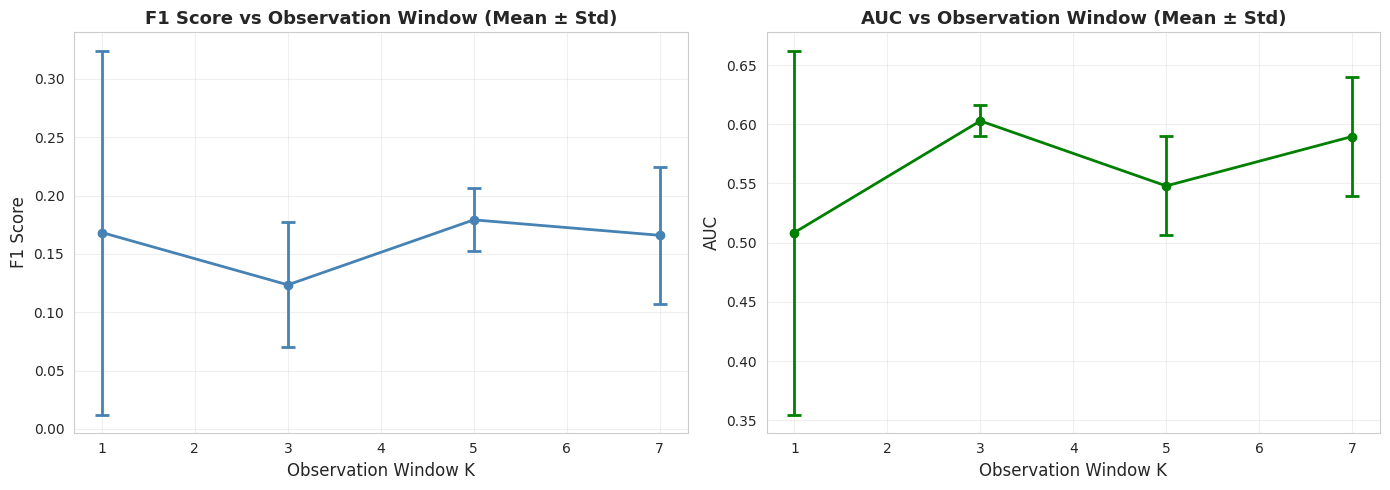

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Score with error bars
ax = axes[0]
f1_means = summary_df['F1_mean'].values
f1_stds = summary_df['F1_std'].values
ax.errorbar(CONFIG['observation_windows'], f1_means, yerr=f1_stds,
            marker='o', linewidth=2, capsize=5, capthick=2, color='steelblue')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Score vs Observation Window (Mean ± Std)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# AUC with error bars
ax = axes[1]
auc_means = summary_df['AUC_mean'].values
auc_stds = summary_df['AUC_std'].values
ax.errorbar(CONFIG['observation_windows'], auc_means, yerr=auc_stds,
            marker='o', linewidth=2, capsize=5, capthick=2, color='green')
ax.set_xlabel('Observation Window K', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.set_title('AUC vs Observation Window (Mean ± Std)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [15]:
# Save aggregated summary statistics
summary_df.to_csv(RESULTS_DIR / 'multi_seed_summary_statistics.csv', index=False)
print(f"Saved summary statistics to {RESULTS_DIR / 'multi_seed_summary_statistics.csv'}")

# Save all results (detailed)
all_results_df.to_csv(RESULTS_DIR / 'all_seeds_all_metrics.csv', index=False)
print(f"Saved all metrics to {RESULTS_DIR / 'all_seeds_all_metrics.csv'}")

print(f"\nAll results saved to: {RESULTS_DIR}")

Saved summary statistics to ../../results/static_gcn_multi_seed/multi_seed_summary_statistics.csv
Saved all metrics to ../../results/static_gcn_multi_seed/all_seeds_all_metrics.csv

All results saved to: ../../results/static_gcn_multi_seed
